# Webcam Live on Jupyter

This example shows you how to perform a live webcam playback on Jupyter lab.

It is required to attach a webcam before running the following code.

In [1]:
import numpy as np
import cv2
from IPython import display
from PIL import Image
import matplotlib.pyplot as py
%matplotlib inline

## Normal live webcam playback

In [2]:
def showVideo(device_index=0, scale=0.25):
    try:
        cap = cv2.VideoCapture(device_index)
    except:
        print("Cannot Open Device.")
    try:
        ret, frame = cap.read()
        
        while(ret==True):
            ret, frame = cap.read()

            if not ret:
                cap.release()
                print ("Released Video Resource.")
                break
            resized = cv2.resize(frame, (0, 0), fx = scale, fy = scale)
            _,ret_array = cv2.imencode('.jpg', resized) #this fixed the pipeline issue as the imshow was converting to png.
            i = display.Image(data=ret_array)
            display.display(i)
            display.clear_output(wait=True)

    except KeyboardInterrupt:
        print("Released Video Resource from KeyboardInterrupt.")
    finally:
        cap.release()

In [3]:
import cv2
import numpy as np

MODE = "MPI"

if MODE == "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [[1, 0], [1, 2], [1, 5], [2, 3], [3, 4], [5, 6], [6, 7], [1, 8], [8, 9], [9, 10], [1, 11], [11, 12], [12, 13], [0, 14], [0, 15], [14, 16], [15, 17]]
elif MODE == "MPI":
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0, 1], [1, 2], [2, 3], [3, 4], [1, 5], [5, 6], [6, 7], [1, 14], [14, 8], [8, 9], [9, 10], [14, 11], [11, 12], [12, 13]]

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

frame = cv2.imread("single.jpeg")
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (368, 368), (0, 0, 0), swapRB=False, crop=False)
net.setInput(inpBlob)
output = net.forward()


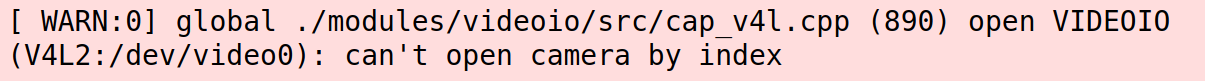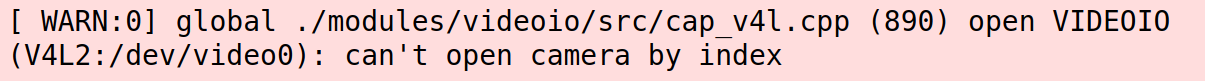

## Live webcam playback with filters

In [4]:
def showVideoWithFilter(device_index=0, scale=0.5, filter_name=None):
    import cv2
    import numpy as np
    from IPython import display

    MODE = "MPI"

    if MODE == "COCO":
        protoFile = "pose/coco/pose_deploy_linevec.prototxt"
        weightsFile = "pose/coco/pose_iter_440000.caffemodel"
        nPoints = 18
        POSE_PAIRS = [[1, 0], [1, 2], [1, 5], [2, 3], [3, 4], [5, 6], [6, 7], [1, 8], [8, 9], [9, 10], [1, 11], [11, 12], [12, 13], [0, 14], [0, 15], [14, 16], [15, 17]]
    elif MODE == "MPI":
        protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
        weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
        nPoints = 15
        POSE_PAIRS = [[0, 1], [1, 2], [2, 3], [3, 4], [1, 5], [5, 6], [6, 7], [1, 14], [14, 8], [8, 9], [9, 10], [14, 11], [11, 12], [12, 13]]

    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

    try:
        cap = cv2.VideoCapture(device_index, cv2.CAP_V4L2)
        if not cap.isOpened():
            print("Cannot Open Device.")
            return

        while True:
            ret, frame = cap.read()
            if not ret:
                print("Released Video Resource.")
                break

            resized = cv2.resize(frame, (0, 0), fx=scale, fy=scale)
            filtered = resized

            if filter_name is None:
                pass
            elif filter_name == 'canny':
                filtered = cv2.Canny(resized, 100, 110)
            elif filter_name == 'blur':
                filtered = cv2.GaussianBlur(resized, (5, 5), 0)
            elif filter_name == 'openpose':
                inpBlob = cv2.dnn.blobFromImage(resized, 1.0 / 255, (368, 368), (0, 0, 0), swapRB=False, crop=False)
                net.setInput(inpBlob)
                output = net.forward()
                H, W = output.shape[2], output.shape[3]

                points = []
                for i in range(nPoints):
                    probMap = output[0, i, :, :]
                    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
                    x = (resized.shape[1] * point[0]) / W
                    y = (resized.shape[0] * point[1]) / H

                    if prob > threshold:
                        points.append((int(x), int(y)))
                    else:
                        points.append(None)

                for pair in POSE_PAIRS:
                    partA = pair[0]
                    partB = pair[1]

                    if points[partA] and points[partB]:
                        cv2.line(filtered, points[partA], points[partB], (0, 255, 255), 1)
                        cv2.circle(filtered, points[partA], 4, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
                        cv2.circle(filtered, points[partB], 4, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            else:
                print("Chosen filter is not supported.")
                break

            _, ret_array = cv2.imencode('.jpg', filtered)
            i = display.Image(data=ret_array)
            display.display(i)
            display.clear_output(wait=True)

    except KeyboardInterrupt:
        print("Released Video Resource from KeyboardInterrupt.")
    finally:
        cap.release()


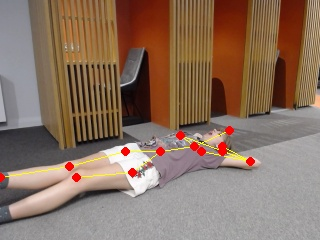

In [ ]:
showVideoWithFilter(0, 0.5, 'openpose') # or use 'blur' instead of 'canny'.

## Reference

[1] https://raymondlo84.medium.com/how-to-run-webcam-closer-to-real-time-performance-on-jupyter-notebook-python-3-in-2021-284c6c6364c6